In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import sys

sys.path.append(os.path.dirname('./ml/tio_dataset'))
sys.path.append(os.path.dirname('./ml/models'))
sys.path.append(os.path.dirname('./ml/metrics'))
sys.path.append(os.path.dirname('./ml/utils'))
sys.path.append(os.path.dirname('./ml/models/activates'))
sys.path.append(os.path.dirname('./ml/models.building_blocks'))

In [3]:
from models.ResUnet import ResUNet, ResUNet2d
from models.unet_deepsup import Unet_MSS
from models.CycleGAN import VanGan
from building_blocks import VG_discriminator, VG_discriminator2d

from tio_dataset import TioDataset
from VG_controller import VG_Controller

from utils import save_model, get_total_params, load_pretrainned

In [4]:
train_settings  = {
    "patch_shape" : (64, 64, 32),
    "patches_per_volume" : 32,
    "patches_queue_length" : 2048,
    "batch_size" : 16,
    "num_workers": 4,
    "sampler": "weighted" #"uniform",#
}

# val_settings  = {
#     "patch_shape" : (32, 32, 32),
#     "patches_per_volume" : 32,
#     "patches_queue_length" : 1440,
#     "batch_size" : 8,
#     "num_workers": 4,
#     "sampler": "uniform",#"weighted" #"uniform",#
# }

test_settings  = {
    "patch_shape" : (256, 256, 128),
    "overlap_shape" : (32, 32, 16),
    "batch_size" : 1,
    "num_workers": 4,
}

#data_dir = "/home/msst/Documents/medtech/MainData"
data_dir = "/home/msst/Documents/medtech/data/GAN_MRA_train_resampled_0.4"
dataset = TioDataset(data_dir,
                 train_settings=train_settings,
                 val_settings=None,
                 test_settings=test_settings)

In [5]:
import torch.nn as nn
modules_for_3d = {
    'gen_IS': Unet_MSS(channels_coef=16, minimax_out=False),
    #'gen_IS': ResUNet(channels_coef=12, use_input_noise=True, use_decoder_noise=True,
    #                  out_act=nn.Identity(), minimax_out=False),
    'gen_SI': ResUNet(channels_coef=8, use_input_noise=True, use_decoder_noise=True,
                      out_act=nn.Identity(), minimax_out=False),
    'disc_I': VG_discriminator(channels_coef=8),#, use_input_noise=False, use_layer_noise=True),
    'disc_S': VG_discriminator(channels_coef=8)#, use_input_noise=False, use_layer_noise=True),
}

model = VanGan(modules_for_3d)
print("model params number:", get_total_params(model))

model params number: 9358533


In [8]:
import torch
import torch.nn as nn
from torch.optim.lr_scheduler import ExponentialLR
import torchio as tio

from metrics import (DiscriminatorLoss, GeneratorLoss,
                     SSIM3D, soft_dice_cldice, CycleLoss)

from metrics import (DICE_Metric, JAC_Metric, SN_Metric, SP_Metric)

controller_config = {
          "device": "cuda",
          "otimizers_settings":{ #lr=0.002
            "gen_IS_opt" : lambda model: torch.optim.Adam(model.parameters(), lr=0.0001, betas=(0.5, 0.9)),
            "gen_SI_opt" : lambda model: torch.optim.Adam(model.parameters(), lr=0.0001, betas=(0.5, 0.9)),
            "disc_I_opt" : lambda model: torch.optim.Adam(model.parameters(), lr=0.0001, betas=(0.5, 0.9)),
            "disc_S_opt" : lambda model: torch.optim.Adam(model.parameters(), lr=0.0001, betas=(0.5, 0.9)),
            "sheduler_fn": lambda optimizer: ExponentialLR(optimizer, 0.95)
            },
          "model": model,
          "losses":{
            "I_cycle_loss_fn": CycleLoss("mae"),#nn.L1Loss(),
            "S_cycle_loss_fn": CycleLoss("mse"), #nn.BCELoss(),
            "reconstruction_loss_fn": CycleLoss("ssim"), #SSIM3D(),
            "segmentation_loss_fn": CycleLoss("explog"), #CycleLoss("cldice"),
            "discriminator_loss_fn": DiscriminatorLoss(),
            "generator_loss_fn": GeneratorLoss(),
            "cycle_lambda" : 10,#3, 
            "identity_lambda" : 5,#10,
            },
          "metrics": {
              "dice" : DICE_Metric(),
              "jac" : JAC_Metric(),
              "sen" : SN_Metric(),
              "spec" : SP_Metric()
              },
          "with_supervised": 1,
          }
vg_controller = VG_Controller(controller_config)

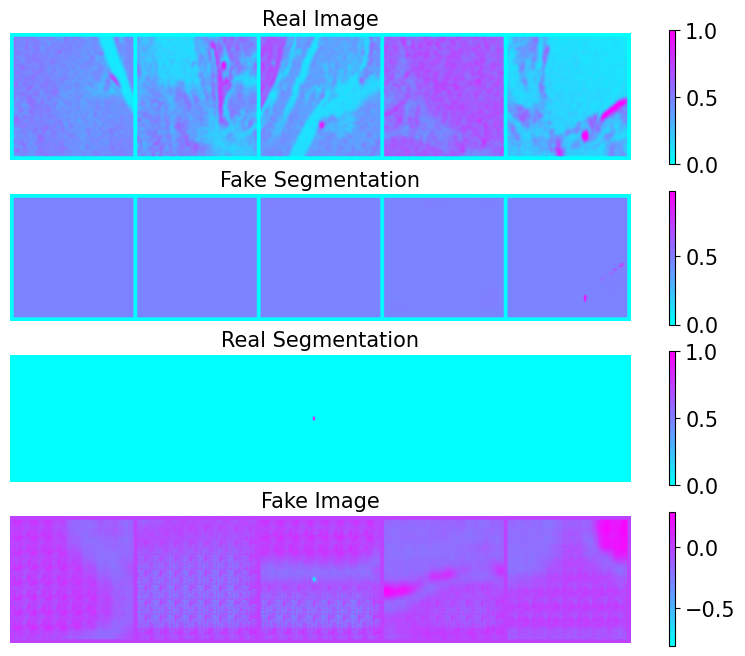

{'gen_IS_loss': 0.2159, 'gen_SI_loss': 0.3849, 'disc_I_loss': 0.2025, 'disc_S_loss': 0.1841, 'segmentation_loss': 0.0614, 'reconstruction_loss': 0.5075}
Epoch 19/251


 44%|███████████████████▎                        | 7/16 [00:24<00:31,  3.46s/it]


KeyboardInterrupt: 

In [10]:
#vg_controller.set_initial_weights()
vg_controller.fit(dataset, 250)

In [7]:
#model_name='GAN_TEST'#"VANGAN_ssim_unsupervised_25_0_1_z"
#save_model(model, '/home/msst/save_folder/saved_models', model_name)

In [8]:
#load_pretrainned(model, '/home/msst/save_folder/saved_models/VANGAN')

In [9]:
data_dir = "/home/msst/save_folder/seg_data/" + model_name
if not os.path.exists(data_dir):
    os.mkdir(data_dir)
vg_controller.predict(dataset.test_dataloader, data_dir)

  0%|                                                     | 0/4 [00:00<?, ?it/s]

dice
jac
sen
spec
tensor(840790.)


 25%|███████████▎                                 | 1/4 [00:04<00:13,  4.66s/it]

dice
jac
sen
spec
tensor(689032.)


 50%|██████████████████████▌                      | 2/4 [00:08<00:08,  4.22s/it]

dice
jac
sen
spec
tensor(763681.)


 75%|█████████████████████████████████▊           | 3/4 [00:12<00:04,  4.17s/it]

dice
jac
sen
spec
tensor(522968.)


100%|█████████████████████████████████████████████| 4/4 [00:16<00:00,  4.14s/it]


[{'sample': 'P2_2',
  'dice': tensor([0.0690]),
  'jac': tensor([0.0357]),
  'sen': tensor([0.0359]),
  'spec': tensor([0.9998])},
 {'sample': 'P4_2',
  'dice': tensor([0.0093]),
  'jac': tensor([0.0047]),
  'sen': tensor([0.0049]),
  'spec': tensor([0.9982])},
 {'sample': 'P1_2',
  'dice': tensor([0.0538]),
  'jac': tensor([0.0276]),
  'sen': tensor([0.0277]),
  'spec': tensor([0.9999])},
 {'sample': 'P5_2',
  'dice': tensor([0.1160]),
  'jac': tensor([0.0616]),
  'sen': tensor([0.0620]),
  'spec': tensor([0.9998])}]